Here I only use AD and HC data and following discussion today (on Dec 21, 2023), 

we use both group for CPD or eig decomp

And I project the X(t) to the SC Laplacian eigvetors U. 

$U^T X'(t) = \Lambda U^T X(t)$

Here I try to estimate continous lambda not change points

**And I use U^TX(t) to select the eigvecs**

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from splines import obt_bsp_basis_Rfn_wrapper

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import display

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu

def _get_test_tb(res_df, base_grp_id=6):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    base = res_df["metric"][res_df["diagnosis"]==base_grp_id]
    grp_name = diag_lab_mapping[base_grp_id]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    diag_ix =  np.setdiff1d([1, 6], [base_grp_id])[0]
    DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
    ttest_res = ttest_ind(DS, base)
    ttest_res1 = mannwhitneyu(DS, base)
    effect_size = (np.mean(DS)-np.mean(base))/np.std(np.concatenate([DS, base]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                    f"{ttest_res1.pvalue:>6.3f}", 
                    f"{effect_size:>6.3f}"])
    
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb


In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [9]:
# load data
num_rois = 246 # the BNA has 246 regions
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");
SC_mat = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["SC_template"];
Dmat_invhalffrac = np.diag(1/(SC_mat.sum(axis=0)**0.5))
Lap_mat = np.eye(num_rois) - Dmat_invhalffrac @ SC_mat @ Dmat_invhalffrac
# col is the eig vectors
eigvals, eigvecs = np.linalg.eigh(Lap_mat); 
sort_idx = np.argsort(np.abs(eigvals))
eigvals, eigvecs = eigvals[sort_idx], eigvecs[:, sort_idx]


# some parameters

num_sps = 321
ac_time = 485

485

In [10]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

# only need AD and HC grp
sub_data_idxs = np.bitwise_or(diag_labs==1, diag_labs == 6);
diag_labs_sub = diag_labs[sub_data_idxs];
sex_labs_sub = sex_labs[sub_data_idxs];
mmse_scores_sub = mmse_scores[sub_data_idxs];

# Run gTVDN

In [11]:
save_dir = RES_ROOT/"congTVDN2grp_projsc_test"
if not save_dir.exists():
    save_dir.mkdir()

In [12]:
paras = edict()
# these two are most influential
#paras.lamb = 1e-7
paras.lamb = 1e-6
#paras.lamb = 1e-6
#paras.lamb = 5e-5
# r is moderately influential
paras.r = 20 
# not very important
# N is the num of basis for B spline
#paras.N = 25
paras.N = 35
# order of B spline, do not change it. 
paras.bsp_ord = 4
paras.T = 1


basis_fn = lambda ts: obt_bsp_basis_Rfn_wrapper(ts, N=paras.N, bsp_ord=paras.bsp_ord);

In [13]:
save_pkl(save_dir/"paras.pkl", paras, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/paras.pkl


## Get data

In [14]:
# get all ts data and divide them into different group
# note the ts are preprocessed (detrend and resample)
from collections import defaultdict as ddict
all_data = []
for sub_ix in range(num_sps):
    ts = _load_data(sub_ix+1)[:num_rois]
    ts = _preprocess_ts(ts);
    all_data.append(eigvecs.T @ ts)
all_data = np.array(all_data);

# only choose 2 grps
all_data = all_data[sub_data_idxs];

In [15]:
# normalized the time to make it within [0, 1]
time_span = np.linspace(0, paras.T, all_data[0].shape[-1]-1)
basis = basis_fn(time_span);

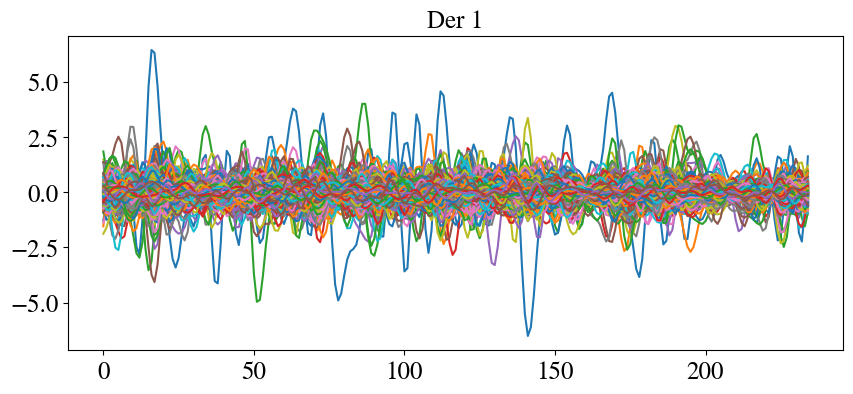

In [16]:
sub_ix = 0 
data = all_data[sub_ix]

plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.title("Der 1")
for roi_ix in range(num_rois):
    plt.plot(data[roi_ix])

<AxesSubplot:>

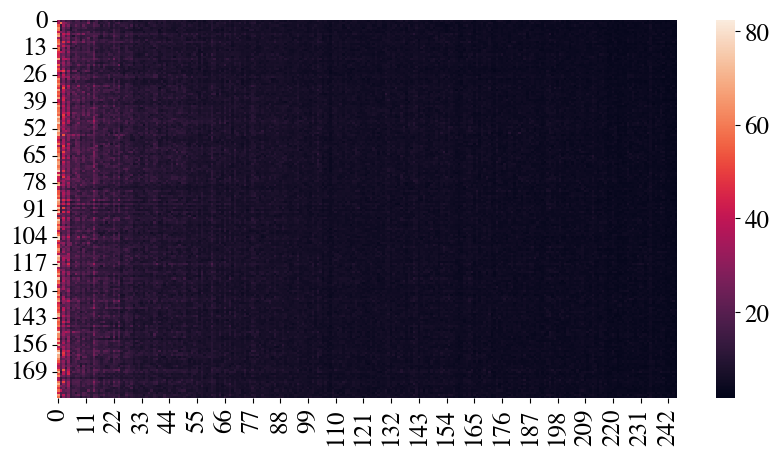

In [17]:
all_data_norm = np.array([np.linalg.norm(all_data[sub_ix], axis=1) 
                          for sub_ix in range(all_data.shape[0])]);
sns.heatmap(all_data_norm)

Text(0.5, 1.0, 'Mean of norm of Z(t) (U^T X(t))')

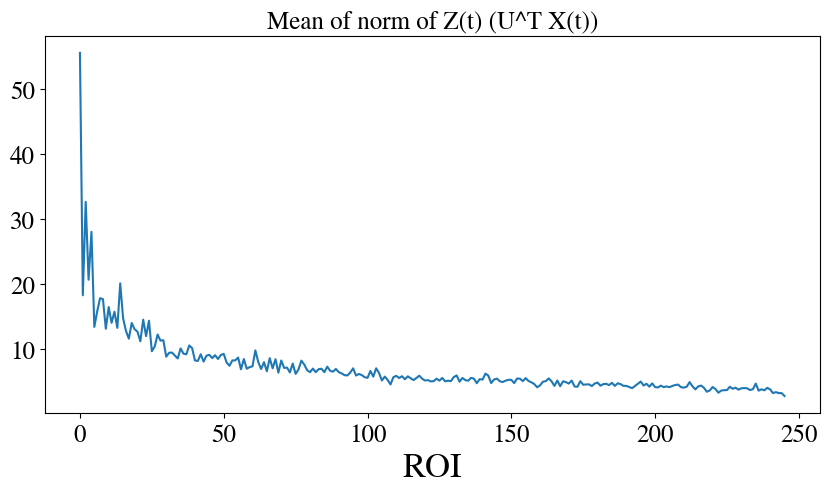

In [18]:
plt.plot(all_data_norm.mean(axis=0))
plt.xlabel("ROI")
plt.title("Mean of norm of Z(t) (U^T X(t))")

In [19]:
sel_idxs = np.where(all_data_norm.mean(axis=0) > 10)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 35, 38, 39])

## Detection

###  Reduce the dim of data

In [20]:
ndXmats = all_data[:, sel_idxs, 1:];
nXmats = all_data[:, sel_idxs, :-1];

### Estimate lam(t)

In [21]:
def get_gam_est(sY, sX, basis, ridge_pen=0):
    """Get gam est based on sY sX and basis
    args:
        sY (array): T vec
        sX (array): T vec
        basis (array): T x N matrix, the bspline basis
    we aim to find a gam vec with N x 1 such that np.mean((sY-basis@gam_est .* sX)**2) is minimal
    return: 
        gam_est (array): N vec
    """
    
    rvec = ((sY * sX)[:, None] * basis).sum(axis=0);
    wbasis = (sX[:, None] * basis);
    lmat = wbasis.T @ wbasis + ridge_pen*np.eye(wbasis.shape[1]);
    gam_est = np.linalg.pinv(lmat) @ rvec;
    return gam_est

In [22]:
def get_gam_est_mul(Y, X, basis, ridge_pen=0):
    """Get gam est based on Y X and basis
    args:
        sY (array): dxT mat
        sX (array): dxT mat
        basis (array): T x N matrix, the bspline basis
    return: 
        gam_ests (array): d x N mat 
    """
    
    d = Y.shape[0]
    gam_ests = []
    for d_ix in range(d):
        sY = Y[d_ix]
        sX = X[d_ix]
        gam_est = get_gam_est(sY, sX, basis, ridge_pen=ridge_pen)
        gam_ests.append(gam_est)
    return np.array(gam_ests)

In [23]:
def _run_fn(sub_ix):
    gam_ests = get_gam_est_mul(ndXmats[sub_ix], nXmats[sub_ix], basis, 0.0);
    lam_ests = basis @ gam_ests.T;
    return lam_ests
with Parallel(n_jobs=20) as parallel:
    cpts = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(nXmats.shape[0]), total=nXmats.shape[0]))
    
save_pkl(save_dir/"lam_ests.pkl", cpts, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 371.86it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/lam_ests.pkl


Text(0, 0.5, 'Lam(t)')

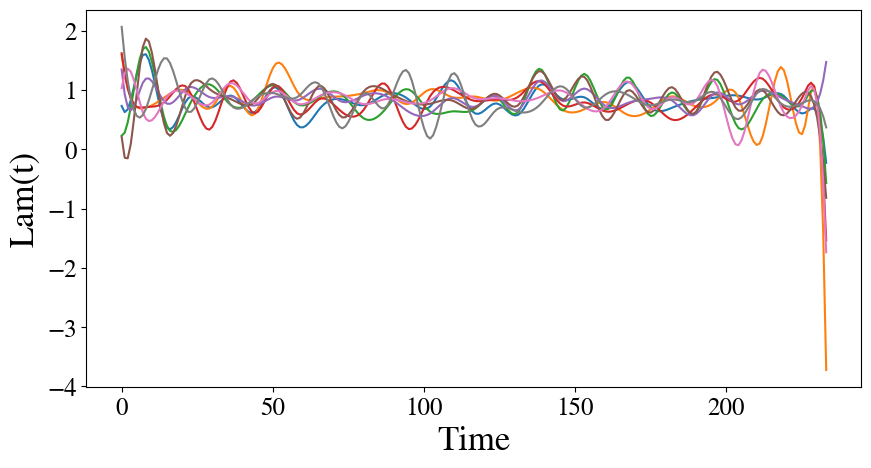

In [24]:
lam_est = cpts[1]
for ix in range(8):
    plt.plot(lam_est[:, ix])
plt.xlabel("Time")
plt.ylabel("Lam(t)")

# Analysis

In [25]:
def _get_dftb(metric):
    res_df = pd.DataFrame({
        "metric": metric,
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    return res_df

In [26]:

save_dir = RES_ROOT/"congTVDN2grp_projsc_test/"
paras = load_pkl(save_dir/"paras.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/paras.pkl


In [27]:
lam_ests = load_pkl(save_dir/"lam_ests.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/lam_ests.pkl


Text(0, 0.5, 'Lam(t)')

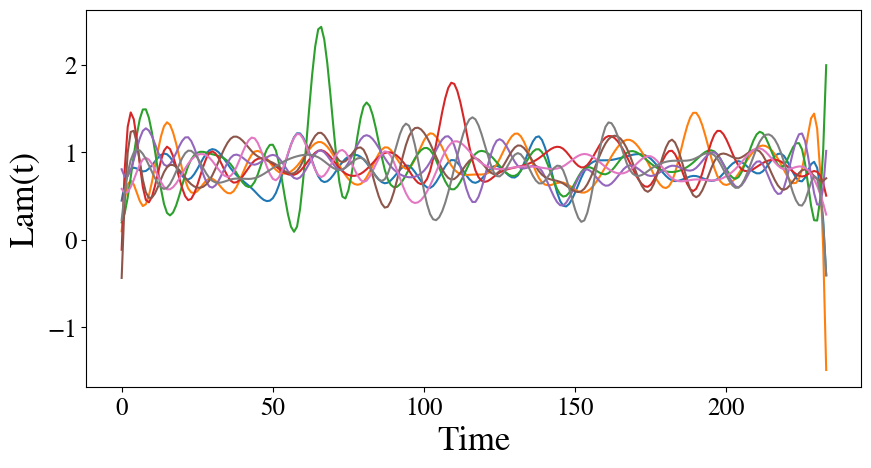

In [28]:
lam_est = lam_ests[0]
for ix in range(8):
    plt.plot(lam_est[:, ix])
plt.xlabel("Time")
plt.ylabel("Lam(t)")

## Correlation

In [29]:
corr_fs = []
for lam_est in lam_ests:
    mat = np.corrcoef(lam_est.T);
    idxs = np.triu_indices_from(mat, k=1)
    corr_fs.append(np.max(np.abs(mat[idxs])))

In [30]:
res_df = _get_dftb(corr_fs)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.725,0.052
(non-param) AD vs HC,0.344,0.052


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.695076,0.073565,0.534851,0.644088,0.687462,0.736011,0.895233
HC,100.0,0.691012,0.080551,0.572393,0.620404,0.676444,0.736482,0.955109


## cpts

In [34]:
def get_cpts(lam_est):
    """Get cpts based on lam est
    args:
        lam_est (array): T x r mat
    return:
        cpts_raw: the cpts and corresponding Uix (from 0)
    """
    raw_segs = np.argmax(np.abs(lam_est), axis=1);
    # i is a cpt if changes start at i
    # index is from 0
    cpts_raw = np.where(np.diff(raw_segs)!=0)[0]+1
    cpts_raw_full = np.concatenate([[0], cpts_raw, [lam_est.shape[0]]])
    return cpts_raw_full, raw_segs[cpts_raw_full[:-1]]

In [35]:
Lmin = 5 
#ncpt_fn = lambda cpts: np.sum(np.diff(cpts) > Lmin)-1
ncpt_fn = lambda cpts: len(cpts)-2

cptss = []
Uidxs = []
for lam_est in lam_ests:
    cptss.append(get_cpts(lam_est)[0])
    Uidxs.append(get_cpts(lam_est)[1])
ncpts = np.array([ncpt_fn(cpts) for cpts in cptss]);

In [36]:
res_df = _get_dftb(ncpts)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.955,-0.008
(non-param) AD vs HC,0.866,-0.008


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,62.353659,4.497934,53.0,59.0,62.0,65.75,72.0
HC,100.0,62.390000,4.160650,51.0,60.0,62.0,65.00,71.0


## Dwell time

In [37]:
dwells =[np.diff(cpts) for cpts in cptss];
max_dwells = np.array([np.max(dwell) for dwell in dwells]);
mean_dwells = np.array([np.mean(dwell) for dwell in dwells]);

In [38]:
# get the dwell time for each U
dwells_perU = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perU[sub_ix, u_ix] = np.sum(dwell[Uidx==u_ix])
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = _get_dftb(dwells_perU[:, u_ix])
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.765,-0.045
(non-param) AD vs HC,0.781,-0.045


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.463415,6.164805,0.0,2.0,7.0,11.0,26.0
HC,100.0,7.740000,6.227375,0.0,3.0,6.5,12.0,27.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.185,0.197
(non-param) AD vs HC,0.374,0.197


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,9.463415,7.410695,0.0,4.0,8.0,14.0,33.0
HC,100.0,8.150000,5.915866,0.0,4.0,8.0,11.0,26.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.431,-0.117
(non-param) AD vs HC,0.259,-0.117


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.609756,6.539068,0.0,2.25,6.5,12.75,27.0
HC,100.0,8.340000,5.922428,0.0,4.00,8.0,11.25,27.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.949,0.009
(non-param) AD vs HC,0.895,0.009


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,8.073171,6.541002,0.0,3.0,7.0,11.00,28.0
HC,100.0,8.010000,6.753218,0.0,2.0,7.0,11.25,29.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.599,-0.078
(non-param) AD vs HC,0.150,-0.078


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.00,6.885304,0.0,1.0,3.0,9.0,34.0
HC,100.0,6.49,5.664875,0.0,2.0,5.0,10.0,23.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.735,0.051
(non-param) AD vs HC,0.456,0.051


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.5,5.511492,0.0,3.25,7.0,10.0,24.0
HC,100.0,7.2,6.258731,0.0,2.00,6.0,11.0,31.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.539,-0.092
(non-param) AD vs HC,0.258,-0.092


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.02439,6.897800,0.0,2.0,5.0,10.00,36.0
HC,100.0,7.61000,5.947404,0.0,3.0,6.0,11.25,23.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.969,0.006
(non-param) AD vs HC,0.904,0.006


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.54878,6.475314,0.0,2.00,6.0,12.0,28.0
HC,100.0,7.51000,6.751723,0.0,2.75,6.0,11.0,34.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.956,0.008
(non-param) AD vs HC,0.899,0.008


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.00,6.004114,0.0,2.0,5.5,11.0,25.0
HC,100.0,6.95,6.105760,0.0,2.0,6.0,10.0,26.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.938,-0.012
(non-param) AD vs HC,0.979,-0.012


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,8.02439,6.501615,0.0,3.0,7.0,10.00,29.0
HC,100.0,8.10000,6.562058,0.0,3.0,7.0,11.25,32.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.447,-0.113
(non-param) AD vs HC,0.557,-0.113


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.317073,5.408905,0.0,2.25,5.0,9.0,20.0
HC,100.0,6.970000,6.015896,0.0,1.00,6.5,11.0,24.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.634,-0.071
(non-param) AD vs HC,0.647,-0.071


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.378049,5.811101,0.0,2.00,5.5,9.00,31.0
HC,100.0,6.800000,6.041941,0.0,1.75,6.0,10.25,27.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.450,0.113
(non-param) AD vs HC,0.620,0.113


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,8.695122,6.699344,0.0,3.25,8.0,12.75,29.0
HC,100.0,7.990000,5.847377,0.0,3.00,8.0,12.00,26.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.204,-0.189
(non-param) AD vs HC,0.256,-0.189


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.182927,5.427702,0.0,1.25,5.0,9.00,21.0
HC,100.0,7.320000,6.408454,0.0,2.00,6.5,10.25,32.0


lam ix is 14:


Test,Pval,Effect size
*AD vs HC,0.023,-0.336
(non-param) *AD vs HC,0.020,-0.336


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.585366,5.149496,0.0,1.00,4.0,8.0,21.0
HC,100.0,7.400000,5.467997,0.0,2.75,7.0,11.0,22.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.071,0.268
(non-param) *AD vs HC,0.049,0.268


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,8.804878,6.422259,0.0,4.00,9.0,12.0,25.0
HC,100.0,7.100000,6.201173,0.0,2.75,6.0,10.0,31.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.807,0.037
(non-param) AD vs HC,0.399,0.037


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.829268,5.372093,0.0,3.0,5.0,10.75,22.0
HC,100.0,6.610000,6.472779,0.0,1.0,5.0,9.25,28.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.746,0.048
(non-param) AD vs HC,0.991,0.048


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.743902,6.447913,0.0,3.0,6.0,11.00,31.0
HC,100.0,7.450000,5.756639,0.0,3.0,7.0,11.25,29.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.983,0.003
(non-param) AD vs HC,0.674,0.003


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.731707,6.146461,0.0,3.00,7.0,12.0,26.0
HC,100.0,7.710000,7.212916,0.0,1.75,7.0,12.0,41.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.507,-0.099
(non-param) AD vs HC,0.421,-0.099


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.304878,5.669257,0.0,1.0,5.5,10.0,21.0
HC,100.0,6.870000,5.725461,0.0,2.0,6.0,10.0,24.0


lam ix is 20:


Test,Pval,Effect size
AD vs HC,0.781,0.041
(non-param) AD vs HC,0.916,0.041


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.402439,7.116074,0.0,2.0,5.5,11.00,30.0
HC,100.0,7.130000,6.094633,0.0,2.0,6.0,10.25,27.0


lam ix is 21:


Test,Pval,Effect size
AD vs HC,0.248,0.172
(non-param) AD vs HC,0.277,0.172


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.560976,6.065685,0.0,2.00,7.0,11.0,29.0
HC,100.0,6.560000,5.561992,0.0,1.75,6.0,10.0,23.0


lam ix is 22:


Test,Pval,Effect size
AD vs HC,0.601,0.078
(non-param) AD vs HC,0.783,0.078


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.54878,6.484840,0.0,2.25,6.5,11.0,29.0
HC,100.0,7.08000,5.573531,0.0,2.00,7.0,10.0,24.0


lam ix is 23:


Test,Pval,Effect size
AD vs HC,0.383,0.130
(non-param) AD vs HC,0.829,0.130


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,8.146341,7.925770,0.0,2.0,6.0,13.0,45.0
HC,100.0,7.240000,6.058836,0.0,2.0,7.0,10.0,26.0


lam ix is 24:


Test,Pval,Effect size
AD vs HC,0.320,-0.148
(non-param) AD vs HC,0.411,-0.148


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.402439,5.388281,0.0,2.0,5.0,10.75,24.0
HC,100.0,7.240000,5.824227,0.0,2.0,7.0,11.00,21.0


lam ix is 25:


Test,Pval,Effect size
AD vs HC,0.275,-0.163
(non-param) AD vs HC,0.303,-0.163


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.853659,5.400325,0.0,1.0,5.0,8.0,19.0
HC,100.0,6.780000,5.887120,0.0,2.0,6.0,11.0,23.0


lam ix is 26:


Test,Pval,Effect size
AD vs HC,0.586,-0.081
(non-param) AD vs HC,0.407,-0.081


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.658537,6.074069,0.0,1.0,6.0,9.0,23.0
HC,100.0,7.140000,5.799721,0.0,2.0,6.0,11.0,23.0


lam ix is 27:


Test,Pval,Effect size
AD vs HC,0.188,0.196
(non-param) AD vs HC,0.206,0.196


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,8.256098,6.312463,0.0,3.0,7.5,12.75,22.0
HC,100.0,7.060000,5.872071,0.0,2.0,6.0,10.00,26.0


lam ix is 28:


Test,Pval,Effect size
AD vs HC,0.683,-0.061
(non-param) AD vs HC,0.583,-0.061


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.914634,6.315181,0.0,3.0,7.0,11.75,30.0
HC,100.0,8.290000,6.044106,0.0,3.0,8.0,13.00,28.0


lam ix is 29:


Test,Pval,Effect size
AD vs HC,0.778,0.042
(non-param) AD vs HC,0.982,0.042


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.45122,6.678050,0.0,2.0,7.0,11.00,35.0
HC,100.0,7.19000,5.804378,0.0,2.0,6.0,10.25,23.0


lam ix is 30:


Test,Pval,Effect size
AD vs HC,0.731,-0.051
(non-param) AD vs HC,0.983,-0.051


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,6.609756,5.862111,0.0,2.00,6.0,9.0,33.0
HC,100.0,6.920000,6.206351,0.0,1.75,6.0,9.0,22.0


lam ix is 31:


Test,Pval,Effect size
AD vs HC,0.354,0.138
(non-param) AD vs HC,0.097,0.138


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.914634,5.298966,0.0,4.00,7.0,11.0,21.0
HC,100.0,7.050000,6.925834,0.0,1.75,6.0,11.0,37.0


In [39]:
# get the dwell time for each U
dwells_perUm = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perUm[sub_ix, u_ix] = np.mean(dwell[Uidx==u_ix]) if (Uidx==u_ix).sum() > 0 else 0
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df =  _get_dftb(dwells_perUm[:, u_ix])
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.453,-0.112
(non-param) AD vs HC,0.323,-0.112


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.082724,2.224812,0.0,1.125,3.000000,4.5,9.0
HC,100.0,3.325167,2.112387,0.0,1.500,3.666667,5.0,9.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.874,0.024
(non-param) AD vs HC,0.746,0.024


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.375097,1.765486,0.0,2.083333,3.416667,4.500000,9.0
HC,100.0,3.330381,1.980462,0.0,2.000000,3.000000,4.233333,10.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.144,-0.217
(non-param) AD vs HC,0.177,-0.217


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,2.977526,1.917474,0.0,1.5,3.0,4.312500,8.0
HC,100.0,3.404500,1.982571,0.0,2.0,3.5,4.666667,9.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.926,-0.014
(non-param) AD vs HC,0.797,-0.014


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.171516,1.829946,0.0,2.0,3.166667,4.0,8.0
HC,100.0,3.197167,1.890098,0.0,2.0,3.366667,4.5,7.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.194,-0.193
(non-param) AD vs HC,0.217,-0.193


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,2.625968,2.035412,0.0,1.0,3.0,4.0,9.0
HC,100.0,3.001500,1.849167,0.0,1.5,3.0,4.5,8.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.257,0.169
(non-param) AD vs HC,0.384,0.169


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.548026,2.255395,0.0,2.0,3.416667,5.000,11.0
HC,100.0,3.177810,2.124401,0.0,1.5,3.000000,4.625,8.5


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.066,-0.273
(non-param) AD vs HC,0.087,-0.273


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,2.948287,2.088951,0.0,1.0,3.000000,4.333333,8.0
HC,100.0,3.569000,2.379658,0.0,2.0,3.666667,5.000000,11.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.333,0.144
(non-param) AD vs HC,0.403,0.144


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.241667,2.123974,0.0,1.541667,3.125,4.7875,8.5
HC,100.0,2.960944,1.775914,0.0,2.000000,3.000,4.2500,6.5


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.746,-0.048
(non-param) AD vs HC,0.819,-0.048


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,2.896748,1.982647,0.0,1.125,3.0,4.229167,8.0
HC,100.0,2.991500,1.937331,0.0,2.000,3.0,4.050000,8.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.880,0.023
(non-param) AD vs HC,0.954,0.023


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.363995,2.345134,0.0,1.6875,3.000000,4.729167,10.0
HC,100.0,3.314881,2.031375,0.0,2.0000,3.166667,4.517857,8.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.540,0.091
(non-param) AD vs HC,0.631,0.091


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.069106,2.311804,0.0,1.5,3.000000,4.0,11.0
HC,100.0,2.861452,2.239720,0.0,1.0,2.583333,4.0,12.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.560,0.087
(non-param) AD vs HC,0.349,0.087


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.432520,2.361714,0.0,2.0,3.333333,5.000,9.0
HC,100.0,3.218405,2.539830,0.0,1.0,3.000000,4.375,12.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.822,0.034
(non-param) AD vs HC,0.926,0.034


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.313618,2.143010,0.0,2.0,3.00,4.1875,9.0
HC,100.0,3.243833,2.014846,0.0,2.0,3.25,4.3750,10.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.841,-0.030
(non-param) AD vs HC,0.542,-0.030


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.143902,2.506998,0.0,1.083333,3.000000,4.625,10.0
HC,100.0,3.214000,2.201876,0.0,1.000000,3.083333,5.000,10.0


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.323,-0.147
(non-param) AD vs HC,0.187,-0.147


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,2.750610,2.210243,0.0,1.000000,2.583333,3.916667,9.0
HC,100.0,3.065833,2.070423,0.0,1.916667,2.900000,4.500000,9.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.301,0.154
(non-param) AD vs HC,0.245,0.154


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.464228,2.164415,0.0,2.0,3.45,4.766667,10.0
HC,100.0,3.140750,2.035030,0.0,2.0,3.00,4.000000,11.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.071,0.268
(non-param) AD vs HC,0.094,0.268


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.302033,2.209858,0.0,1.666667,3.000000,4.625,11.0
HC,100.0,2.731000,2.021746,0.0,1.000000,2.666667,4.000,10.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.481,0.105
(non-param) AD vs HC,0.608,0.105


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.381301,2.234060,0.0,2.0000,3.0,5.000000,11.0
HC,100.0,3.155762,2.065166,0.0,1.9375,3.0,4.333333,10.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.575,0.084
(non-param) AD vs HC,0.520,0.084


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.300407,2.086177,0.0,2.0,3.25,4.333333,9.0
HC,100.0,3.115071,2.316814,0.0,1.0,3.00,4.600000,9.5


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.081,-0.259
(non-param) AD vs HC,0.158,-0.259


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,2.689024,1.98451,0.0,1.0,3.000000,4.000,7.5
HC,100.0,3.260667,2.34495,0.0,1.5,3.291667,4.375,9.0


lam ix is 20:


Test,Pval,Effect size
AD vs HC,0.704,0.057
(non-param) AD vs HC,0.841,0.057


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.349593,2.464927,0.0,1.50,3.0,5.25,11.0
HC,100.0,3.216833,2.242720,0.0,1.25,3.0,4.75,9.0


lam ix is 21:


Test,Pval,Effect size
AD vs HC,0.676,0.062
(non-param) AD vs HC,0.803,0.062


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.181911,1.932116,0.0,2.0,3.416667,4.312500,8.5
HC,100.0,3.054667,2.130476,0.0,1.0,3.000000,4.666667,9.0


lam ix is 22:


Test,Pval,Effect size
AD vs HC,0.744,-0.049
(non-param) AD vs HC,0.711,-0.049


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.303659,2.318727,0.0,2.000,3.000000,4.458333,11.0
HC,100.0,3.419000,2.407950,0.0,1.875,3.333333,4.500000,11.0


lam ix is 23:


Test,Pval,Effect size
AD vs HC,0.218,0.183
(non-param) AD vs HC,0.355,0.183


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.521748,2.705761,0.0,1.125,3.333333,5.300,13.0
HC,100.0,3.074833,2.177173,0.0,1.375,3.000000,4.425,10.0


lam ix is 24:


Test,Pval,Effect size
AD vs HC,0.834,-0.031
(non-param) AD vs HC,0.637,-0.031


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.146748,2.099409,0.0,1.625,3.125,4.458333,11.0
HC,100.0,3.213333,2.155999,0.0,1.500,3.500,4.541667,9.0


lam ix is 25:


Test,Pval,Effect size
AD vs HC,0.629,-0.072
(non-param) AD vs HC,0.436,-0.072


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,2.878252,2.357851,0.0,1.000000,2.5,4.4375,8.0
HC,100.0,3.038667,2.105864,0.0,1.333333,3.1,4.5000,7.0


lam ix is 26:


Test,Pval,Effect size
AD vs HC,0.082,-0.259
(non-param) AD vs HC,0.084,-0.259


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,2.937398,2.267980,0.0,1.0,2.9,4.333333,9.0
HC,100.0,3.551500,2.421494,0.0,2.0,3.5,5.000000,11.0


lam ix is 27:


Test,Pval,Effect size
AD vs HC,0.439,0.115
(non-param) AD vs HC,0.388,0.115


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.383740,2.229262,0.0,1.8125,3.35,5.000,9.0
HC,100.0,3.131333,2.150302,0.0,2.0000,3.00,4.375,9.0


lam ix is 28:


Test,Pval,Effect size
AD vs HC,0.428,-0.118
(non-param) AD vs HC,0.299,-0.118


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.242276,2.261206,0.0,2.0,3.000000,5.000000,12.0
HC,100.0,3.493333,1.995805,0.0,2.0,3.333333,4.616667,9.0


lam ix is 29:


Test,Pval,Effect size
AD vs HC,0.966,0.006
(non-param) AD vs HC,0.978,0.006


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.380081,2.222496,0.0,2.000000,3.291667,5.0,8.5
HC,100.0,3.365667,2.245405,0.0,1.916667,3.000000,5.0,9.0


lam ix is 30:


Test,Pval,Effect size
AD vs HC,0.285,0.159
(non-param) AD vs HC,0.356,0.159


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.407085,2.412821,0.0,1.500,3.125,4.928571,10.0
HC,100.0,3.038167,2.223524,0.0,1.375,3.000,4.500000,9.0


lam ix is 31:


Test,Pval,Effect size
AD vs HC,0.194,0.193
(non-param) AD vs HC,0.168,0.193


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.507724,2.109759,0.0,2.0,3.375,4.625000,9.0
HC,100.0,3.063667,2.417442,0.0,1.0,3.000,4.616667,12.0


In [40]:
# get the dwell time for each U
dwells_perUmax = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perUmax[sub_ix, u_ix] = np.max(dwell[Uidx==u_ix]) if (Uidx==u_ix).sum() > 0 else 0
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = _get_dftb(dwells_perUmax[:, u_ix])
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.514,-0.097
(non-param) AD vs HC,0.480,-0.097


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.378049,3.153052,0.0,1.25,4.5,7.0,12.0
HC,100.0,4.680000,3.051345,0.0,2.00,5.0,7.0,10.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.592,0.080
(non-param) AD vs HC,0.518,0.080


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.926829,2.618927,0.0,3.0,5.0,7.0,11.0
HC,100.0,4.710000,2.779052,0.0,3.0,5.0,6.0,12.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.087,-0.254
(non-param) AD vs HC,0.101,-0.254


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.256098,2.972346,0.0,2.0,4.0,7.0,10.0
HC,100.0,5.010000,2.921515,0.0,3.0,5.0,7.0,12.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.659,-0.066
(non-param) AD vs HC,0.559,-0.066


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.414634,2.721434,0.0,3.0,4.0,6.0,11.0
HC,100.0,4.600000,2.891995,0.0,2.0,5.0,7.0,10.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.186,-0.197
(non-param) AD vs HC,0.110,-0.197


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.50,2.998971,0.0,1.0,3.0,5.75,10.0
HC,100.0,4.07,2.786167,0.0,2.0,4.0,6.00,12.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.334,0.144
(non-param) AD vs HC,0.243,0.144


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.817073,2.855050,0.0,3.0,5.0,7.0,11.0
HC,100.0,4.380000,3.164768,0.0,2.0,4.0,7.0,13.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.240,-0.175
(non-param) AD vs HC,0.209,-0.175


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.02439,3.018362,0.0,1.0,4.0,6.0,11.0
HC,100.0,4.54000,2.861871,0.0,2.0,4.0,7.0,11.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.319,0.148
(non-param) AD vs HC,0.418,0.148


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.573171,3.193475,0.0,2.0,4.0,7.0,11.0
HC,100.0,4.140000,2.655355,0.0,2.0,4.0,6.0,10.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.919,0.015
(non-param) AD vs HC,0.966,0.015


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.134146,3.045994,0.0,1.25,4.0,6.75,13.0
HC,100.0,4.090000,2.785587,0.0,2.00,4.0,6.00,10.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.765,0.045
(non-param) AD vs HC,0.819,0.045


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.670732,3.107358,0.0,2.0,5.0,7.0,11.0
HC,100.0,4.540000,2.768583,0.0,2.0,4.5,7.0,11.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.825,-0.033
(non-param) AD vs HC,0.836,-0.033


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.95122,2.875621,0.0,2.0,4.0,6.0,11.0
HC,100.0,4.05000,3.076056,0.0,1.0,4.0,6.0,12.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.753,0.047
(non-param) AD vs HC,0.693,0.047


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.353659,2.995354,0.0,2.0,4.0,7.0,10.0
HC,100.0,4.210000,3.105209,0.0,1.0,4.0,6.0,12.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.954,0.009
(non-param) AD vs HC,0.985,0.009


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.634146,2.821926,0.0,2.0,5.0,7.0,11.0
HC,100.0,4.610000,2.799333,0.0,3.0,5.0,7.0,12.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.368,-0.134
(non-param) AD vs HC,0.378,-0.134


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.926829,2.980515,0.0,1.25,3.0,6.0,10.0
HC,100.0,4.330000,3.008590,0.0,1.00,5.0,7.0,12.0


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.138,-0.221
(non-param) AD vs HC,0.113,-0.221


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.719512,3.056159,0.0,1.0,3.0,6.00,10.0
HC,100.0,4.380000,2.908643,0.0,2.0,5.0,6.25,11.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.106,0.240
(non-param) AD vs HC,0.103,0.240


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.853659,2.919166,0.0,2.0,5.0,7.0,11.0
HC,100.0,4.180000,2.664317,0.0,2.0,4.0,6.0,11.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.356,0.138
(non-param) AD vs HC,0.271,0.138


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.439024,2.981828,0.0,2.0,4.0,7.0,11.0
HC,100.0,4.010000,3.214535,0.0,1.0,3.5,6.0,12.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.677,0.062
(non-param) AD vs HC,0.729,0.062


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.573171,3.022674,0.0,2.0,5.0,6.0,12.0
HC,100.0,4.390000,2.884634,0.0,2.0,5.0,6.0,11.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.919,-0.015
(non-param) AD vs HC,0.916,-0.015


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.402439,2.832177,0.0,2.0,4.0,7.0,11.0
HC,100.0,4.450000,3.358616,0.0,1.0,5.0,7.0,13.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.343,-0.141
(non-param) AD vs HC,0.290,-0.141


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.865854,3.033810,0.0,1.0,4.0,6.0,11.0
HC,100.0,4.290000,2.965441,0.0,2.0,4.0,7.0,10.0


lam ix is 20:


Test,Pval,Effect size
AD vs HC,0.921,0.015
(non-param) AD vs HC,0.983,0.015


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.317073,3.310582,0.0,2.00,4.0,7.0,13.0
HC,100.0,4.270000,3.071061,0.0,1.75,4.0,7.0,12.0


lam ix is 21:


Test,Pval,Effect size
AD vs HC,0.334,0.144
(non-param) AD vs HC,0.413,0.144


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.426829,2.884743,0.0,2.0,4.0,6.0,11.0
HC,100.0,4.010000,2.886734,0.0,1.0,4.0,6.0,10.0


lam ix is 22:


Test,Pval,Effect size
AD vs HC,0.916,0.016
(non-param) AD vs HC,0.895,0.016


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.54878,3.209371,0.0,2.0,4.0,6.75,12.0
HC,100.0,4.50000,3.003365,0.0,2.0,4.5,7.00,11.0


lam ix is 23:


Test,Pval,Effect size
AD vs HC,0.497,0.101
(non-param) AD vs HC,0.675,0.101


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.609756,3.394826,0.0,1.25,5.0,7.0,13.0
HC,100.0,4.290000,2.941500,0.0,1.75,4.5,7.0,12.0


lam ix is 24:


Test,Pval,Effect size
AD vs HC,0.548,-0.090
(non-param) AD vs HC,0.539,-0.090


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.231707,2.885891,0.0,2.0,4.0,6.0,11.0
HC,100.0,4.500000,3.076467,0.0,2.0,5.0,7.0,11.0


lam ix is 25:


Test,Pval,Effect size
AD vs HC,0.570,-0.085
(non-param) AD vs HC,0.618,-0.085


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.756098,2.933674,0.0,1.0,4.0,6.0,9.0
HC,100.0,4.000000,2.831996,0.0,2.0,4.0,6.0,11.0


lam ix is 26:


Test,Pval,Effect size
AD vs HC,0.139,-0.220
(non-param) AD vs HC,0.157,-0.220


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.902439,2.921228,0.0,1.0,4.0,6.0,10.0
HC,100.0,4.570000,3.092039,0.0,2.0,5.0,7.0,11.0


lam ix is 27:


Test,Pval,Effect size
AD vs HC,0.438,0.115
(non-param) AD vs HC,0.441,0.115


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.585366,2.989493,0.0,2.0,5.0,7.00,11.0
HC,100.0,4.250000,2.822618,0.0,2.0,4.0,6.25,10.0


lam ix is 28:


Test,Pval,Effect size
AD vs HC,0.635,-0.071
(non-param) AD vs HC,0.669,-0.071


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.585366,2.939519,0.0,3.0,5.0,7.0,12.0
HC,100.0,4.790000,2.843724,0.0,3.0,5.0,7.0,11.0


lam ix is 29:


Test,Pval,Effect size
AD vs HC,0.792,0.039
(non-param) AD vs HC,0.838,0.039


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.50,3.084209,0.0,2.0,4.5,7.0,12.0
HC,100.0,4.38,3.011024,0.0,2.0,5.0,7.0,11.0


lam ix is 30:


Test,Pval,Effect size
AD vs HC,0.973,-0.005
(non-param) AD vs HC,0.972,-0.005


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.195122,2.895032,0.0,2.00,4.0,6.0,12.0
HC,100.0,4.210000,3.042776,0.0,1.75,4.0,7.0,11.0


lam ix is 31:


Test,Pval,Effect size
AD vs HC,0.071,0.268
(non-param) AD vs HC,0.077,0.268


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.890244,2.802142,0.0,3.0,5.0,7.0,12.0
HC,100.0,4.080000,3.142025,0.0,1.0,4.0,7.0,12.0


In [41]:
res_df = _get_dftb(max_dwells)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.516,0.097
(non-param) AD vs HC,0.562,0.097


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.341463,1.135505,8.0,9.0,10.0,11.0,13.0
HC,100.0,10.230000,1.162156,7.0,9.0,10.0,11.0,13.0


In [42]:
res_df = _get_dftb(mean_dwells)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.905,0.018
(non-param) AD vs HC,0.866,0.018


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.711954,0.263349,3.205479,3.505767,3.714286,3.900000,4.333333
HC,100.0,3.707404,0.246773,3.250000,3.545455,3.714286,3.836066,4.500000


## Mean lam(t) over time 

In [43]:
lam_ests_mean = np.array([np.mean(lam_est, axis=0) for lam_est in lam_ests]);

for lam_ix in range(lam_ests_mean.shape[1]):
    res_df = pd.DataFrame({
        "metric": lam_ests_mean[:, lam_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {lam_ix}:")
    display(_get_test_tb(res_df))
    #display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.280,-0.161
(non-param) AD vs HC,0.438,-0.161


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.550,0.089
(non-param) AD vs HC,0.721,0.089


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.550,-0.089
(non-param) AD vs HC,0.495,-0.089


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.131,-0.225
(non-param) AD vs HC,0.119,-0.225


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.244,-0.174
(non-param) AD vs HC,0.088,-0.174


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.897,-0.019
(non-param) AD vs HC,0.738,-0.019


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.257,0.169
(non-param) AD vs HC,0.397,0.169


lam ix is 7:


Test,Pval,Effect size
*AD vs HC,0.006,0.407
(non-param) *AD vs HC,0.007,0.407


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.632,0.071
(non-param) AD vs HC,0.330,0.071


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.877,-0.023
(non-param) AD vs HC,0.893,-0.023


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.210,-0.186
(non-param) AD vs HC,0.340,-0.186


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.718,0.054
(non-param) AD vs HC,0.582,0.054


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.447,-0.113
(non-param) AD vs HC,0.380,-0.113


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.564,0.086
(non-param) AD vs HC,0.291,0.086


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.770,-0.044
(non-param) AD vs HC,0.920,-0.044


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.339,0.142
(non-param) AD vs HC,0.360,0.142


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.681,-0.061
(non-param) AD vs HC,0.849,-0.061


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.989,-0.002
(non-param) AD vs HC,0.860,-0.002


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.392,-0.128
(non-param) AD vs HC,0.491,-0.128


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.203,-0.189
(non-param) AD vs HC,0.272,-0.189


lam ix is 20:


Test,Pval,Effect size
AD vs HC,0.736,-0.050
(non-param) AD vs HC,0.755,-0.050


lam ix is 21:


Test,Pval,Effect size
AD vs HC,0.092,0.250
(non-param) AD vs HC,0.083,0.250


lam ix is 22:


Test,Pval,Effect size
AD vs HC,0.706,0.056
(non-param) AD vs HC,0.687,0.056


lam ix is 23:


Test,Pval,Effect size
AD vs HC,0.557,-0.088
(non-param) AD vs HC,0.357,-0.088


lam ix is 24:


Test,Pval,Effect size
AD vs HC,0.615,-0.075
(non-param) AD vs HC,0.451,-0.075


lam ix is 25:


Test,Pval,Effect size
AD vs HC,0.773,0.043
(non-param) AD vs HC,0.573,0.043


lam ix is 26:


Test,Pval,Effect size
AD vs HC,0.062,-0.277
(non-param) AD vs HC,0.126,-0.277


lam ix is 27:


Test,Pval,Effect size
AD vs HC,0.605,-0.077
(non-param) AD vs HC,0.550,-0.077


lam ix is 28:


Test,Pval,Effect size
AD vs HC,0.947,0.010
(non-param) AD vs HC,0.956,0.010


lam ix is 29:


Test,Pval,Effect size
AD vs HC,0.385,-0.129
(non-param) AD vs HC,0.381,-0.129


lam ix is 30:


Test,Pval,Effect size
AD vs HC,0.659,0.066
(non-param) AD vs HC,0.529,0.066


lam ix is 31:


Test,Pval,Effect size
AD vs HC,0.865,0.025
(non-param) AD vs HC,0.718,0.025


In [44]:
lam_ests_mean_abs = np.array([np.mean(np.abs(lam_est), axis=0) for lam_est in lam_ests]);

for lam_ix in range(lam_ests_mean_abs.shape[1]):
    res_df = pd.DataFrame({
        "metric": lam_ests_mean_abs[:, lam_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {lam_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.434,-0.117
(non-param) AD vs HC,0.718,-0.117


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.833830,0.030446,0.743963,0.816419,0.836591,0.854652,0.893356
HC,100.0,0.837398,0.030596,0.767226,0.817352,0.832643,0.856492,0.921348


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.532,0.093
(non-param) AD vs HC,0.594,0.093


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.847002,0.032444,0.780302,0.829454,0.844599,0.864782,0.941057
HC,100.0,0.843839,0.035058,0.753089,0.821561,0.841368,0.864175,0.994220


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.973,-0.005
(non-param) AD vs HC,0.880,-0.005


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.846527,0.028862,0.786985,0.823098,0.846850,0.864761,0.904990
HC,100.0,0.846666,0.025734,0.773195,0.829929,0.848387,0.864479,0.911993


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.159,-0.210
(non-param) AD vs HC,0.182,-0.210


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.844680,0.032592,0.779584,0.819115,0.842934,0.863790,0.937589
HC,100.0,0.851189,0.029433,0.779738,0.832040,0.847272,0.872408,0.926099


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.171,-0.204
(non-param) AD vs HC,0.059,-0.204


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.836112,0.034163,0.765371,0.813976,0.832516,0.848419,0.970358
HC,100.0,0.842616,0.029697,0.780183,0.817218,0.846483,0.861631,0.913115


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.943,0.011
(non-param) AD vs HC,0.610,0.011


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.843703,0.029491,0.741895,0.827414,0.844828,0.859602,0.902550
HC,100.0,0.843373,0.031992,0.759736,0.823383,0.841705,0.861392,0.934881


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.191,0.195
(non-param) AD vs HC,0.287,0.195


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.843289,0.033270,0.781698,0.823612,0.844492,0.861247,1.005508
HC,100.0,0.837315,0.028097,0.775416,0.818199,0.835771,0.858693,0.914865


lam ix is 7:


Test,Pval,Effect size
*AD vs HC,0.003,0.439
(non-param) *AD vs HC,0.004,0.439


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.854782,0.030815,0.791038,0.836213,0.852733,0.874834,0.933817
HC,100.0,0.841845,0.026928,0.789977,0.823889,0.839641,0.859238,0.918239


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.803,0.037
(non-param) AD vs HC,0.516,0.037


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.838695,0.029676,0.749256,0.822925,0.839081,0.859679,0.904986
HC,100.0,0.837644,0.027027,0.782478,0.821481,0.835555,0.851283,0.914346


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.746,-0.048
(non-param) AD vs HC,0.798,-0.048


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.842466,0.027290,0.782349,0.826335,0.842178,0.864748,0.912254
HC,100.0,0.843897,0.031432,0.784417,0.820308,0.845966,0.864374,0.958087


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.302,-0.154
(non-param) AD vs HC,0.448,-0.154


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.839057,0.030234,0.770285,0.820053,0.837764,0.86125,0.910341
HC,100.0,0.843539,0.028024,0.771866,0.824700,0.843119,0.86305,0.911797


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.731,0.051
(non-param) AD vs HC,0.559,0.051


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.837904,0.026958,0.749763,0.821273,0.836647,0.856550,0.894364
HC,100.0,0.836452,0.029382,0.772811,0.818182,0.836789,0.851757,0.916199


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.249,-0.172
(non-param) AD vs HC,0.211,-0.172


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.843502,0.032653,0.753346,0.826886,0.842088,0.861851,0.943598
HC,100.0,0.848438,0.024868,0.793184,0.829470,0.847549,0.868466,0.904027


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.713,0.055
(non-param) AD vs HC,0.311,0.055


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.844529,0.025533,0.781725,0.829238,0.846016,0.861617,0.904732
HC,100.0,0.842960,0.030773,0.777110,0.820325,0.837885,0.856842,0.923796


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.880,-0.022
(non-param) AD vs HC,0.936,-0.022


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.838459,0.028750,0.750491,0.821654,0.836596,0.854699,0.928550
HC,100.0,0.839113,0.029429,0.776371,0.818201,0.836303,0.856795,0.910081


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.300,0.154
(non-param) AD vs HC,0.356,0.154


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.845726,0.026502,0.802431,0.824196,0.842295,0.864322,0.911940
HC,100.0,0.841156,0.031802,0.758852,0.820104,0.838846,0.858809,0.931542


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.465,-0.109
(non-param) AD vs HC,0.702,-0.109


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.839237,0.030021,0.772651,0.822312,0.842477,0.856504,0.906153
HC,100.0,0.842638,0.032064,0.790591,0.814793,0.842101,0.864979,0.934341


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.725,0.052
(non-param) AD vs HC,0.750,0.052


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.847688,0.028565,0.786999,0.828152,0.845879,0.866595,0.941079
HC,100.0,0.846241,0.026770,0.787845,0.828574,0.843947,0.863728,0.914940


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.337,-0.143
(non-param) AD vs HC,0.475,-0.143


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.843805,0.031380,0.732553,0.825528,0.843964,0.865501,0.922705
HC,100.0,0.847997,0.027392,0.776812,0.830511,0.847525,0.861061,0.946544


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.293,-0.157
(non-param) AD vs HC,0.444,-0.157


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.839779,0.027925,0.762572,0.819324,0.842737,0.862022,0.889802
HC,100.0,0.844390,0.030447,0.766753,0.829240,0.846365,0.860637,0.914444


lam ix is 20:


Test,Pval,Effect size
AD vs HC,0.846,0.029
(non-param) AD vs HC,0.916,0.029


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.838570,0.033045,0.767655,0.811692,0.837028,0.856339,0.951307
HC,100.0,0.837645,0.031016,0.757767,0.821436,0.836919,0.855832,0.922477


lam ix is 21:


Test,Pval,Effect size
*AD vs HC,0.028,0.325
(non-param) *AD vs HC,0.037,0.325


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.842676,0.027702,0.791717,0.818817,0.842303,0.858100,0.898490
HC,100.0,0.833419,0.028456,0.773968,0.817051,0.830310,0.853467,0.933904


lam ix is 22:


Test,Pval,Effect size
AD vs HC,0.805,0.037
(non-param) AD vs HC,0.794,0.037


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.840249,0.035725,0.740916,0.816815,0.839704,0.860697,0.947644
HC,100.0,0.839068,0.028661,0.771631,0.822707,0.840035,0.855736,0.926095


lam ix is 23:


Test,Pval,Effect size
AD vs HC,0.557,-0.088
(non-param) AD vs HC,0.303,-0.088


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.837909,0.034603,0.758267,0.818426,0.835149,0.855736,0.955112
HC,100.0,0.840741,0.030270,0.765331,0.822667,0.838346,0.859650,0.950935


lam ix is 24:


Test,Pval,Effect size
AD vs HC,0.451,-0.112
(non-param) AD vs HC,0.500,-0.112


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.839750,0.029782,0.758228,0.822053,0.839829,0.856694,0.924298
HC,100.0,0.843053,0.028990,0.784966,0.822211,0.842163,0.864513,0.921037


lam ix is 25:


Test,Pval,Effect size
AD vs HC,0.669,0.064
(non-param) AD vs HC,0.456,0.064


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.839705,0.025343,0.770717,0.818965,0.845729,0.856763,0.908885
HC,100.0,0.838039,0.026757,0.779311,0.821211,0.834582,0.855576,0.903425


lam ix is 26:


Test,Pval,Effect size
*AD vs HC,0.038,-0.308
(non-param) AD vs HC,0.077,-0.308


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.829684,0.029869,0.745218,0.806490,0.833100,0.853389,0.900568
HC,100.0,0.838810,0.028704,0.762136,0.814879,0.837917,0.858548,0.918580


lam ix is 27:


Test,Pval,Effect size
AD vs HC,0.821,-0.034
(non-param) AD vs HC,0.787,-0.034


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.841765,0.031572,0.771686,0.822701,0.841035,0.861734,0.949433
HC,100.0,0.842786,0.029014,0.769645,0.818308,0.844562,0.860318,0.916747


lam ix is 28:


Test,Pval,Effect size
AD vs HC,0.962,-0.007
(non-param) AD vs HC,0.940,-0.007


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.843784,0.032403,0.784749,0.816934,0.844577,0.865671,0.916125
HC,100.0,0.843996,0.026759,0.766551,0.830626,0.841348,0.860742,0.921728


lam ix is 29:


Test,Pval,Effect size
AD vs HC,0.673,-0.063
(non-param) AD vs HC,0.624,-0.063


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.835743,0.027786,0.784412,0.813013,0.836568,0.850714,0.916105
HC,100.0,0.837629,0.031574,0.749901,0.817801,0.834651,0.861568,0.911067


lam ix is 30:


Test,Pval,Effect size
AD vs HC,0.687,0.060
(non-param) AD vs HC,0.531,0.060


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.841092,0.029238,0.779297,0.820088,0.843440,0.862525,0.902201
HC,100.0,0.839292,0.030413,0.758936,0.821710,0.837102,0.856399,0.926457


lam ix is 31:


Test,Pval,Effect size
AD vs HC,0.446,0.114
(non-param) AD vs HC,0.554,0.114


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.842235,0.029498,0.78547,0.820269,0.840235,0.863293,0.923609
HC,100.0,0.839144,0.025102,0.78964,0.821611,0.839088,0.855255,0.904063


In [45]:
def _fs_fn(lam_est, typ=1, is_abs=False):
    if is_abs:
        lam_est = np.abs(lam_est)
        
    if typ == 1:
        return np.mean(lam_est)
    elif typ == 2:
        return np.median(lam_est)
    elif typ == 3:
        return np.mean(lam_est, axis=0).max()
    elif typ == 4:
        return np.median(lam_est, axis=0).max()




for typ in [1, 2, 3, 4]:
    for is_abs in [True, False]:
        fs = np.array([_fs_fn(lam_est, typ=typ, is_abs=is_abs) for lam_est in lam_ests]);
        res_df = pd.DataFrame({
            "metric": fs,
            "sex": sex_labs_sub, 
            "diagnosis": diag_labs_sub
        })
        res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
        display(_get_test_tb(res_df))
        #display(res_df.groupby("diagnosis1")["metric"].describe())

Test,Pval,Effect size
AD vs HC,0.862,-0.026
(non-param) AD vs HC,0.970,-0.026


Test,Pval,Effect size
AD vs HC,0.667,-0.064
(non-param) AD vs HC,0.778,-0.064


Test,Pval,Effect size
AD vs HC,0.957,0.008
(non-param) AD vs HC,0.963,0.008


Test,Pval,Effect size
AD vs HC,0.977,0.004
(non-param) AD vs HC,0.985,0.004


Test,Pval,Effect size
AD vs HC,0.496,0.101
(non-param) AD vs HC,0.970,0.101


Test,Pval,Effect size
AD vs HC,0.447,0.113
(non-param) AD vs HC,0.916,0.113


Test,Pval,Effect size
AD vs HC,0.912,-0.016
(non-param) AD vs HC,0.733,-0.016


Test,Pval,Effect size
AD vs HC,0.933,-0.013
(non-param) AD vs HC,0.714,-0.013


## PSD of lam(t)

In [46]:
from scipy.signal import welch
def get_psd(ts, freq_lmts=[0.008, 0.08]):
    """
    Computes the power spectral density (PSD) of a given time series using Welch's method.
    
    Parameters:
    -----------
    ts : numpy.ndarray
        The time series data. Shape: (n_channels, n_samples).
    freq_lmts : list, optional
        The frequency limits (in Hz) to compute the PSD. Default: [0.008, 0.08].
    
    Returns:
    --------
    fs : numpy.ndarray
        The frequency values (in Hz) of the PSD. Shape: (n_freqs,).
    psds_dB_sm : numpy.ndarray
        The PSD values (in dB) of the time series data after smoothing. Shape: (n_channels, n_freqs).
    """
    lpf = np.array([1, 2, 5, 2, 1]) 
    lpf = lpf/np.sum(lpf)
    ac_time = 485
    fs, psds = welch(ts, fs=ts.shape[1]/ac_time, nperseg=int(ts.shape[1]/2))
    psds_dB = 10*np.log10(psds) # to dB
    psds_dB_sm = []
    for roi_ix in range(ts.shape[0]):
        cen = np.convolve(psds_dB[roi_ix],lpf,'valid')
        tmp = np.concatenate([psds_dB[roi_ix, :2], 
                              cen, 
                              psds_dB[roi_ix, -2:]])
        psds_dB_sm.append(tmp)
    psds_dB_sm = np.array(psds_dB_sm)
    kpidxs = np.bitwise_and(fs>=freq_lmts[0], fs<=freq_lmts[1])
    return fs[kpidxs], psds_dB_sm[:, kpidxs]
    

In [47]:
nsubj = len(lam_ests)
psds = []
for sub_ix in range(nsubj):
    freqs, psd = get_psd(lam_ests[sub_ix].T)
    psds.append(psd.T)
psds = np.array(psds);

In [48]:
mpsd_perfreq = psds.mean(axis=1);
nu = mpsd_perfreq.shape[-1]
for uidx in range(nu):
    res_df = _get_dftb(mpsd_perfreq[:, uidx])
    print(f"lam ix is {uidx}:")
    display(_get_test_tb(res_df))

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.506,-0.099
(non-param) AD vs HC,0.340,-0.099


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.756,0.046
(non-param) AD vs HC,0.873,0.046


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.638,0.070
(non-param) AD vs HC,0.818,0.070


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.438,0.116
(non-param) AD vs HC,0.223,0.116


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.428,-0.118
(non-param) AD vs HC,0.479,-0.118


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.141,0.219
(non-param) *AD vs HC,0.039,0.219


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.580,-0.082
(non-param) AD vs HC,0.652,-0.082


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.088,-0.254
(non-param) AD vs HC,0.135,-0.254


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.522,-0.095
(non-param) AD vs HC,0.493,-0.095


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.335,0.144
(non-param) AD vs HC,0.233,0.144


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.201,-0.190
(non-param) AD vs HC,0.194,-0.190


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.748,-0.048
(non-param) AD vs HC,0.900,-0.048


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.267,-0.165
(non-param) AD vs HC,0.291,-0.165


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.124,-0.229
(non-param) AD vs HC,0.137,-0.229


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.117,-0.233
(non-param) AD vs HC,0.051,-0.233


lam ix is 15:


Test,Pval,Effect size
*AD vs HC,0.000,-0.560
(non-param) *AD vs HC,0.000,-0.560


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.719,-0.054
(non-param) AD vs HC,0.600,-0.054


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.270,-0.164
(non-param) AD vs HC,0.227,-0.164


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.608,0.077
(non-param) AD vs HC,0.473,0.077


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.669,-0.064
(non-param) AD vs HC,0.818,-0.064


lam ix is 20:


Test,Pval,Effect size
AD vs HC,0.350,0.139
(non-param) AD vs HC,0.369,0.139


lam ix is 21:


Test,Pval,Effect size
AD vs HC,0.563,0.086
(non-param) AD vs HC,0.421,0.086


lam ix is 22:


Test,Pval,Effect size
AD vs HC,0.436,-0.116
(non-param) AD vs HC,0.557,-0.116


lam ix is 23:


Test,Pval,Effect size
AD vs HC,0.959,0.008
(non-param) AD vs HC,0.770,0.008


lam ix is 24:


Test,Pval,Effect size
AD vs HC,0.570,0.085
(non-param) AD vs HC,0.704,0.085


lam ix is 25:


Test,Pval,Effect size
AD vs HC,0.605,-0.077
(non-param) AD vs HC,0.518,-0.077


lam ix is 26:


Test,Pval,Effect size
AD vs HC,0.245,0.173
(non-param) AD vs HC,0.296,0.173


lam ix is 27:


Test,Pval,Effect size
AD vs HC,0.110,0.237
(non-param) AD vs HC,0.161,0.237


lam ix is 28:


Test,Pval,Effect size
AD vs HC,0.815,-0.035
(non-param) AD vs HC,0.853,-0.035


lam ix is 29:


Test,Pval,Effect size
AD vs HC,0.142,0.219
(non-param) AD vs HC,0.135,0.219


lam ix is 30:


Test,Pval,Effect size
AD vs HC,0.199,-0.191
(non-param) AD vs HC,0.190,-0.191


lam ix is 31:


Test,Pval,Effect size
*AD vs HC,0.036,0.311
(non-param) *AD vs HC,0.028,0.311


In [49]:
maxpsd_perfreq = psds.max(axis=1);
nu = maxpsd_perfreq.shape[-1]
for uidx in range(nu):
    res_df = _get_dftb(maxpsd_perfreq[:, uidx])
    print(f"lam ix is {uidx}:")
    display(_get_test_tb(res_df))

lam ix is 0:


Test,Pval,Effect size
*AD vs HC,0.025,-0.333
(non-param) *AD vs HC,0.026,-0.333


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.832,-0.032
(non-param) AD vs HC,0.677,-0.032


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.301,-0.154
(non-param) AD vs HC,0.288,-0.154


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.812,0.035
(non-param) AD vs HC,0.772,0.035


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.103,-0.242
(non-param) AD vs HC,0.122,-0.242


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.575,0.084
(non-param) AD vs HC,0.439,0.084


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.153,-0.213
(non-param) AD vs HC,0.178,-0.213


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.171,-0.204
(non-param) AD vs HC,0.154,-0.204


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.684,-0.061
(non-param) AD vs HC,0.580,-0.061


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.980,0.004
(non-param) AD vs HC,0.884,0.004


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.235,-0.177
(non-param) AD vs HC,0.319,-0.177


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.731,-0.051
(non-param) AD vs HC,0.507,-0.051


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.311,-0.151
(non-param) AD vs HC,0.392,-0.151


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.131,-0.225
(non-param) AD vs HC,0.097,-0.225


lam ix is 14:


Test,Pval,Effect size
*AD vs HC,0.019,-0.348
(non-param) *AD vs HC,0.016,-0.348


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.063,-0.276
(non-param) *AD vs HC,0.047,-0.276


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.076,-0.263
(non-param) AD vs HC,0.054,-0.263


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.381,-0.131
(non-param) AD vs HC,0.362,-0.131


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.319,-0.148
(non-param) AD vs HC,0.496,-0.148


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.179,-0.200
(non-param) AD vs HC,0.108,-0.200


lam ix is 20:


Test,Pval,Effect size
AD vs HC,0.596,0.079
(non-param) AD vs HC,0.664,0.079


lam ix is 21:


Test,Pval,Effect size
AD vs HC,0.796,-0.039
(non-param) AD vs HC,0.895,-0.039


lam ix is 22:


Test,Pval,Effect size
AD vs HC,0.261,-0.167
(non-param) AD vs HC,0.134,-0.167


lam ix is 23:


Test,Pval,Effect size
AD vs HC,0.979,-0.004
(non-param) AD vs HC,0.539,-0.004


lam ix is 24:


Test,Pval,Effect size
AD vs HC,0.937,-0.012
(non-param) AD vs HC,0.965,-0.012


lam ix is 25:


Test,Pval,Effect size
AD vs HC,0.298,-0.155
(non-param) AD vs HC,0.341,-0.155


lam ix is 26:


Test,Pval,Effect size
AD vs HC,0.278,0.162
(non-param) AD vs HC,0.331,0.162


lam ix is 27:


Test,Pval,Effect size
AD vs HC,0.458,0.111
(non-param) AD vs HC,0.461,0.111


lam ix is 28:


Test,Pval,Effect size
AD vs HC,0.334,-0.144
(non-param) AD vs HC,0.277,-0.144


lam ix is 29:


Test,Pval,Effect size
AD vs HC,0.217,0.184
(non-param) AD vs HC,0.184,0.184


lam ix is 30:


Test,Pval,Effect size
AD vs HC,0.238,-0.176
(non-param) AD vs HC,0.195,-0.176


lam ix is 31:


Test,Pval,Effect size
AD vs HC,0.201,0.190
(non-param) AD vs HC,0.203,0.190


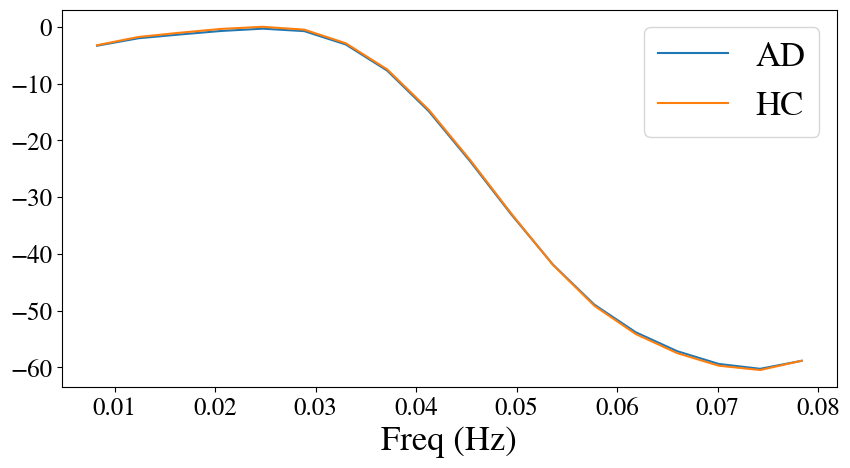

In [51]:
mpsd_perU = psds.mean(axis=2);
AD_psd = mpsd_perU[diag_labs_sub==1].mean(axis=0)
Ctrl_psd = mpsd_perU[diag_labs_sub==6].mean(axis=0)
plt.plot(freqs, AD_psd, label="AD")
plt.plot(freqs, Ctrl_psd, label="HC")
plt.xlabel("Freq (Hz)")
plt.legend()